
# AI/ML Capstone Project: Film Success Prediction

### The research question you intend to answer (in one sentence, if possible)

What are the best strategies and characteristics that can contribute to predicting how successful an upcoming film will be in order to generate the most revenue for business stakeholders and positive staying power in the minds of the average moviegoer in the general public?

### Your expected data source(s) (as either a link to existing data or a sentence describing where you will source the data from)

- Data of high grossing films of the past 25 years that were critically reviewed the most positively
- Preferred genres of film
- Language and cultural impact
- Critical success and how it affects revenue
- Survey results of general interest in physically driving to a movie theater and paying money to watch a film
The techniques you expect to use in your analysis

### Visuals: Histograms, Bar, line

### The techniques you expect to use in your analysis

- Time Series Analysis and Forecasting
- Linear regression (and model selection/regularization in genearl)
- Data preprocessing for multiple datasets
- KNN (maybe for genre classification, determining best type of film, etc.)

### The Expected Results
Determine the optimal factors that will generate the most profit for an upcoming film based on a variety of characteristics such as genre of film, critical success, timing of release, runtime, etc.

### Why this question is important

This question is mainly important to optimize risk management for investors and stakeholders. Since the topic is about best strategies for generating revenue, those involved can best determine if they want to move forward and greenlight a project. In modern times, films along with the process of making them and marketing them are becoming exponentially expensive, increasing risk and cognizance or setting realistic marketing and production budgets.

---

## Datasets

1. **IMDb Basic Movie Titles**  
   - Source: `https://datasets.imdbws.com/title.basics.tsv.gz`

2. **IMDb title ratings**  
   - Source: `https://datasets.imdbws.com/title.ratings.tsv.gz`

3. **TMDB 5000 movies (Kaggle)**  
   - Source: Kaggle dataset: `https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata`


## 1. Load IMDb datasets

In [6]:

# Load IMDb title.basics (feature films only)
basics_path = "title.basics.tsv"
df_basics = pd.read_csv(
    basics_path,
    sep="\t",
    na_values="\\N",
    low_memory=False
)

# Keep only movies
df_basics = df_basics[df_basics["titleType"] == "movie"].copy()

print("IMDb basics (movies only):", df_basics.shape)
df_basics.head()
df_basics.describe()
df_basics.info()


IMDb basics (movies only): (732534, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 732534 entries, 8 to 12091540
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          732534 non-null  object 
 1   titleType       732534 non-null  object 
 2   primaryTitle    732531 non-null  object 
 3   originalTitle   732531 non-null  object 
 4   isAdult         732534 non-null  int64  
 5   startYear       624216 non-null  float64
 6   endYear         0 non-null       float64
 7   runtimeMinutes  462583 non-null  object 
 8   genres          655056 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 55.9+ MB


In [7]:

# Load IMDb title.ratings
ratings_path = "title.ratings.tsv"
df_ratings = pd.read_csv(
    ratings_path,
    sep="\t",
    na_values="\\N",
)

print("IMDb ratings:", df_ratings.shape)
df_ratings.head()
df_ratings.describe()
df_ratings.info()


IMDb ratings: (1604474, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604474 entries, 0 to 1604473
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1604474 non-null  object 
 1   averageRating  1604474 non-null  float64
 2   numVotes       1604474 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 36.7+ MB


### Merge IMDb basics + ratings and basic cleaning

In [8]:

# Merge on tconst (movie identifier)
df_imdb = df_basics.merge(df_ratings, on="tconst", how="inner")

# Convert types
df_imdb["startYear"] = pd.to_numeric(df_imdb["startYear"], errors="coerce")
df_imdb["runtimeMinutes"] = pd.to_numeric(df_imdb["runtimeMinutes"], errors="coerce")
df_imdb["numVotes"] = pd.to_numeric(df_imdb["numVotes"], errors="coerce")
df_imdb["averageRating"] = pd.to_numeric(df_imdb["averageRating"], errors="coerce")

# Drop rows with critical NaNs
df_imdb_clean = df_imdb.dropna(subset=["startYear", "runtimeMinutes", "averageRating", "numVotes"]).copy()

print("IMDb merged:", df_imdb.shape)
print("IMDb after cleaning:", df_imdb_clean.shape)
df_imdb_clean.head()
df_imdb_clean.describe()
df_imdb_clean.info()


IMDb merged: (335633, 11)
IMDb after cleaning: (302590, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 302590 entries, 0 to 335632
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          302590 non-null  object 
 1   titleType       302590 non-null  object 
 2   primaryTitle    302590 non-null  object 
 3   originalTitle   302590 non-null  object 
 4   isAdult         302590 non-null  int64  
 5   startYear       302590 non-null  float64
 6   endYear         0 non-null       float64
 7   runtimeMinutes  302590 non-null  float64
 8   genres          296308 non-null  object 
 9   averageRating   302590 non-null  float64
 10  numVotes        302590 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 27.7+ MB


## 2. Load TMDB 5000 movies (Kaggle)

In [9]:

tmdb_path = "tmdb_5000_movies.csv"
df_tmdb = pd.read_csv(tmdb_path)

print("TMDB raw shape:", df_tmdb.shape)
df_tmdb.head()
df_tmdb.describe()
df_tmdb.info()


TMDB raw shape: (4803, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 

### Select key TMDB columns and clean

In [10]:

# Keep core columns for EDA + modeling
cols_keep = [
    "title",
    "budget",
    "revenue",
    "runtime",
    "vote_average",
    "vote_count",
    "release_date",
    "genres"
]
df_tmdb_small = df_tmdb[cols_keep].copy()

# Replace zeros in budget/revenue with NaN (assume missing/unknown)
df_tmdb_small[["budget", "revenue"]] = df_tmdb_small[["budget", "revenue"]].replace(0, np.nan)

# Convert types
df_tmdb_small["budget"] = pd.to_numeric(df_tmdb_small["budget"], errors="coerce")
df_tmdb_small["revenue"] = pd.to_numeric(df_tmdb_small["revenue"], errors="coerce")
df_tmdb_small["runtime"] = pd.to_numeric(df_tmdb_small["runtime"], errors="coerce")
df_tmdb_small["vote_average"] = pd.to_numeric(df_tmdb_small["vote_average"], errors="coerce")
df_tmdb_small["vote_count"] = pd.to_numeric(df_tmdb_small["vote_count"], errors="coerce")

# Parse release_date and extract year
df_tmdb_small["release_date"] = pd.to_datetime(df_tmdb_small["release_date"], errors="coerce")
df_tmdb_small["release_year"] = df_tmdb_small["release_date"].dt.year

# Drop rows with missing basic info
df_tmdb_clean = df_tmdb_small.dropna(subset=["budget", "revenue", "runtime", "vote_average", "vote_count", "release_year"]).copy()

print("TMDB after cleaning:", df_tmdb_clean.shape)
df_tmdb_clean.head()
df_tmdb_clean.describe()
df_tmdb_clean.info()


TMDB after cleaning: (3229, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 4798
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         3229 non-null   object        
 1   budget        3229 non-null   float64       
 2   revenue       3229 non-null   float64       
 3   runtime       3229 non-null   float64       
 4   vote_average  3229 non-null   float64       
 5   vote_count    3229 non-null   int64         
 6   release_date  3229 non-null   datetime64[ns]
 7   genres        3229 non-null   object        
 8   release_year  3229 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 252.3+ KB


## 3. Feature engineering — extract primary genre

In [11]:

import ast

def extract_primary_genre(genre_json_str):
    """Extract the first genre name from TMDB's JSON-like genre string."""
    try:
        data = ast.literal_eval(genre_json_str)
        if isinstance(data, list) and len(data) > 0 and "name" in data[0]:
            return data[0]["name"]
    except Exception:
        return np.nan
    return np.nan

df_tmdb_clean["primary_genre"] = df_tmdb_clean["genres"].apply(extract_primary_genre)

print("Top 10 primary genres:")
df_tmdb_clean["primary_genre"].value_counts().head(10)


Top 10 primary genres:


,count
primary_genre,
Drama,747
Comedy,634
Action,588
Adventure,288
Horror,197
Crime,141
Thriller,118
Animation,99
Fantasy,93


## 4. EDA — distributions

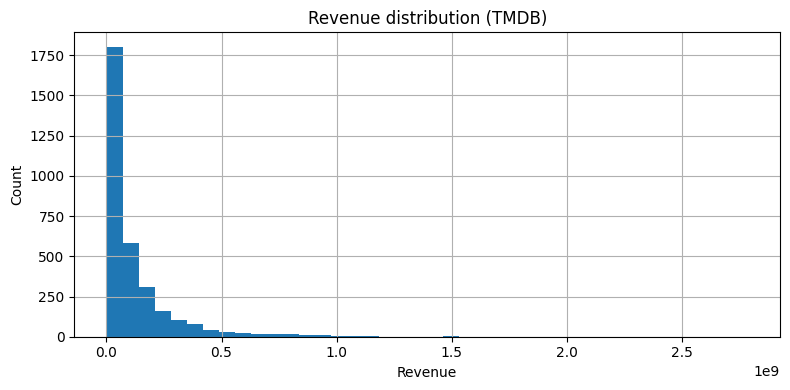

In [12]:

# Revenue distribution
plt.figure(figsize=(8, 4))
df_tmdb_clean["revenue"].hist(bins=40)
plt.title("Revenue distribution (TMDB)")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


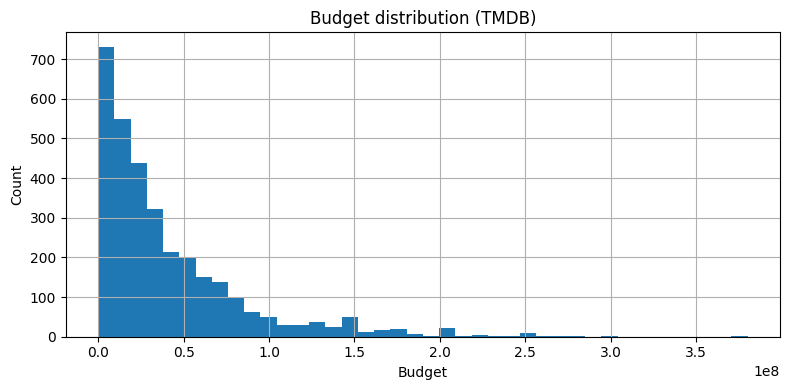

In [13]:

# Budget distribution
plt.figure(figsize=(8, 4))
df_tmdb_clean["budget"].hist(bins=40)
plt.title("Budget distribution (TMDB)")
plt.xlabel("Budget")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


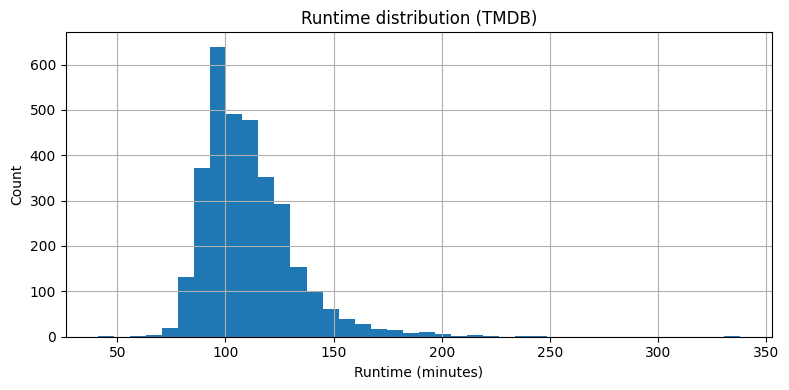

In [14]:

# Runtime distribution
plt.figure(figsize=(8, 4))
df_tmdb_clean["runtime"].hist(bins=40)
plt.title("Runtime distribution (TMDB)")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Revenue vs budget

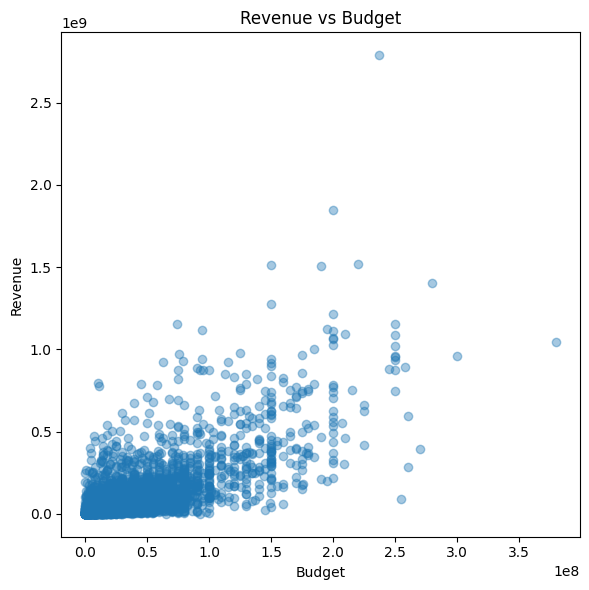

In [15]:

plt.figure(figsize=(6, 6))
plt.scatter(df_tmdb_clean["budget"], df_tmdb_clean["revenue"], alpha=0.4)
plt.title("Revenue vs Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


### Correlation matrix of numeric features

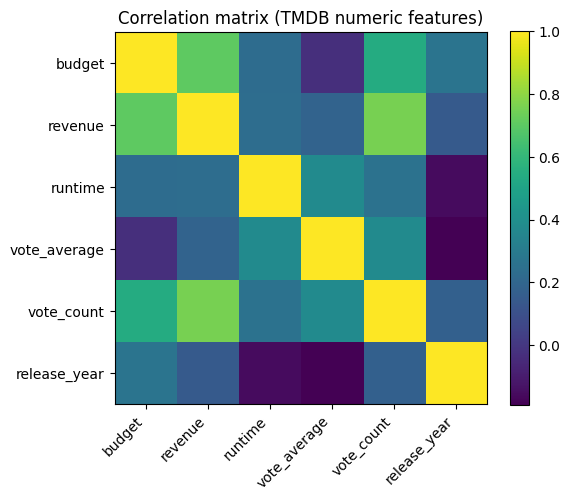

,budget,revenue,runtime,vote_average,vote_count,release_year
budget,1.000000,0.705399,0.229490,-0.031208,0.540165,0.267182
revenue,0.705399,1.000000,0.233074,0.187839,0.756210,0.147443
runtime,0.229490,0.233074,1.000000,0.378641,0.257922,-0.157598
vote_average,-0.031208,0.187839,0.378641,1.000000,0.377658,-0.191197
vote_count,0.540165,0.756210,0.257922,0.377658,1.000000,0.173365
release_year,0.267182,0.147443,-0.157598,-0.191197,0.173365,1.000000


In [16]:

numeric_cols = ["budget", "revenue", "runtime", "vote_average", "vote_count", "release_year"]
corr = df_tmdb_clean[numeric_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.title("Correlation matrix (TMDB numeric features)")
plt.tight_layout()
plt.show()

corr


### Primary genre counts

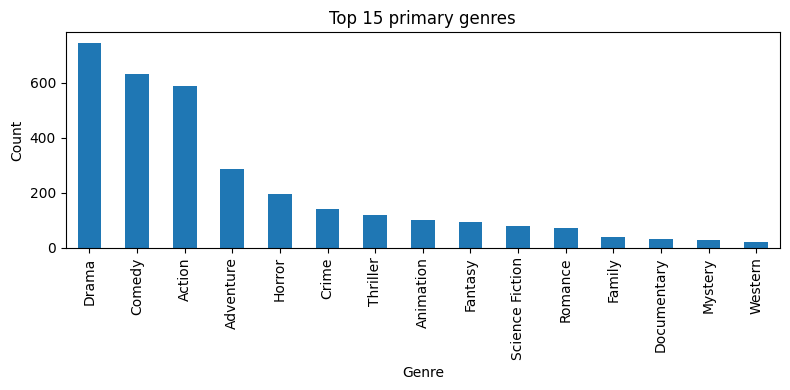

,count
primary_genre,
Drama,747
Comedy,634
Action,588
Adventure,288
Horror,197
Crime,141
Thriller,118
Animation,99
Fantasy,93


In [17]:

genre_counts = df_tmdb_clean["primary_genre"].value_counts().head(15)

plt.figure(figsize=(8, 4))
genre_counts.plot(kind="bar")
plt.title("Top 15 primary genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

genre_counts


## 5. Prepare dataset for baseline Linear Regression

In [18]:

# Keep core modeling features + target
model_cols = [
    "budget",
    "runtime",
    "vote_average",
    "vote_count",
    "release_year",
    "primary_genre",
    "revenue",
]
df_model = df_tmdb_clean[model_cols].dropna().copy()

# One-hot encode primary_genre
df_model = pd.get_dummies(df_model, columns=["primary_genre"], drop_first=True)

print("Modeling dataframe shape:", df_model.shape)
df_model.head()


Modeling dataframe shape: (3228, 24)


,budget,runtime,vote_average,vote_count,release_year,revenue,primary_genre_Adventure,primary_genre_Animation,primary_genre_Comedy,primary_genre_Crime,primary_genre_Documentary,primary_genre_Drama,primary_genre_Family,primary_genre_Fantasy,primary_genre_Foreign,primary_genre_History,primary_genre_Horror,primary_genre_Music,primary_genre_Mystery,primary_genre_Romance,primary_genre_Science Fiction,primary_genre_Thriller,primary_genre_War,primary_genre_Western
0,237000000.0,162.0,7.2,11800,2009.0,2.787965e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,300000000.0,169.0,6.9,4500,2007.0,9.610000e+08,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,245000000.0,148.0,6.3,4466,2015.0,8.806746e+08,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,250000000.0,165.0,7.6,9106,2012.0,1.084939e+09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,260000000.0,132.0,6.1,2124,2012.0,2.841391e+08,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## 6. Baseline model — Linear Regression

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Features and target
X = df_model.drop("revenue", axis=1)
y = df_model["revenue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Baseline Linear Regression results:")
print("R^2:", r2)
print("MAE:", mae)


Baseline Linear Regression results:
R^2: 0.6739589034059638
MAE: 66033168.00053413


### Plot: predicted vs actual revenue

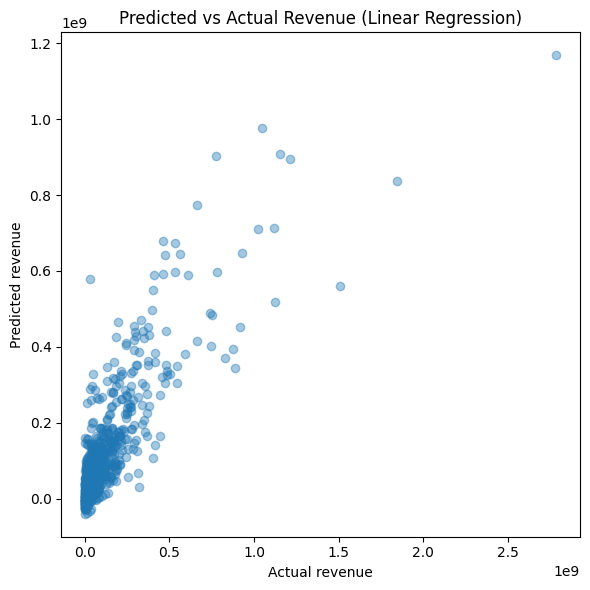

In [20]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.title("Predicted vs Actual Revenue (Linear Regression)")
plt.xlabel("Actual revenue")
plt.ylabel("Predicted revenue")
plt.tight_layout()
plt.show()
